In [157]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from src.Evaluation import disco_score, disco_samples

def disco_score_balanced(X, l):
    disco_values = disco_samples(X, l)
    disco_values_per_cluster = []
    for c in set(l):
        disco_values_per_cluster.append(disco_values[l==c].mean())
    return np.array(disco_values_per_cluster)

# dataset = DensityDatasets.complex9
# dataset = DensityDatasets.aggregation
dataset = RealWorldDatasets.Synth_high
X, l = dataset.standardized_data_cached

ks = range(2, 21)
dctree = DCTree(X, min_points=5, min_points_mr=2)
eps_list = [dctree.get_eps_for_k(k) for k in ks]
kcenter_labels = [dctree.get_k_center(k) for k in ks]
dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]

# kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
# dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [159]:
kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

In [184]:
import pandas as pd
import glob

path = "results/find_dbscan_eps/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
# df_["dataset"] = df_["dataset"].apply(lambda val: eps_list[val-2])
eval_results = df_.to_dict(orient="list")

In [185]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

In [186]:
df

,dataset,measure,run,value,time,process_time,mem_usage
0,2,DISCO,0,0.618416,6.013613,6.626556,27025408
1,2,DBCV,0,0.447083,6.355178,5.313074,27656192
2,2,DCSI,0,0.507246,9.625321,9.003255,34807808
3,2,SILHOUETTE,0,0.467118,1.035564,1.724038,5947392
4,2,S_DBW,0,0.227325,0.402690,0.146322,17887232
...,...,...,...,...,...,...,...
185,19,S_DBW,0,0.987583,0.459598,0.459307,131072
186,19,LCCV,0,0.039412,27.679217,27.678123,-106496
187,19,DBCV,0,0.895159,0.716948,0.716925,24858624
188,19,CVDD,0,0.700912,77.008193,77.165888,-34459648


In [204]:
from src.utils.metrics import SELECTED_METRICS

disco_scores = df.to_numpy()
peak_positions = []
for metric in SELECTED_METRICS:
    values = disco_scores[disco_scores[:, 1] == metric][:,3]
    max_idx = np.argmax(values)
    peak_positions.append([ks[max_idx], values[max_idx]])
peak_positions = np.array(peak_positions)

In [224]:
palette = ["black"] + sns.color_palette("bright")
np.array(list(palette), dtype=object)

array(['black', (0.00784313725490196, 0.24313725490196078, 1.0),
       (1.0, 0.48627450980392156, 0.0),
       (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
       (0.9098039215686274, 0.0, 0.043137254901960784),
       (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
       (0.6235294117647059, 0.2823529411764706, 0.0),
       (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
       (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
       (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)],
      dtype=object)

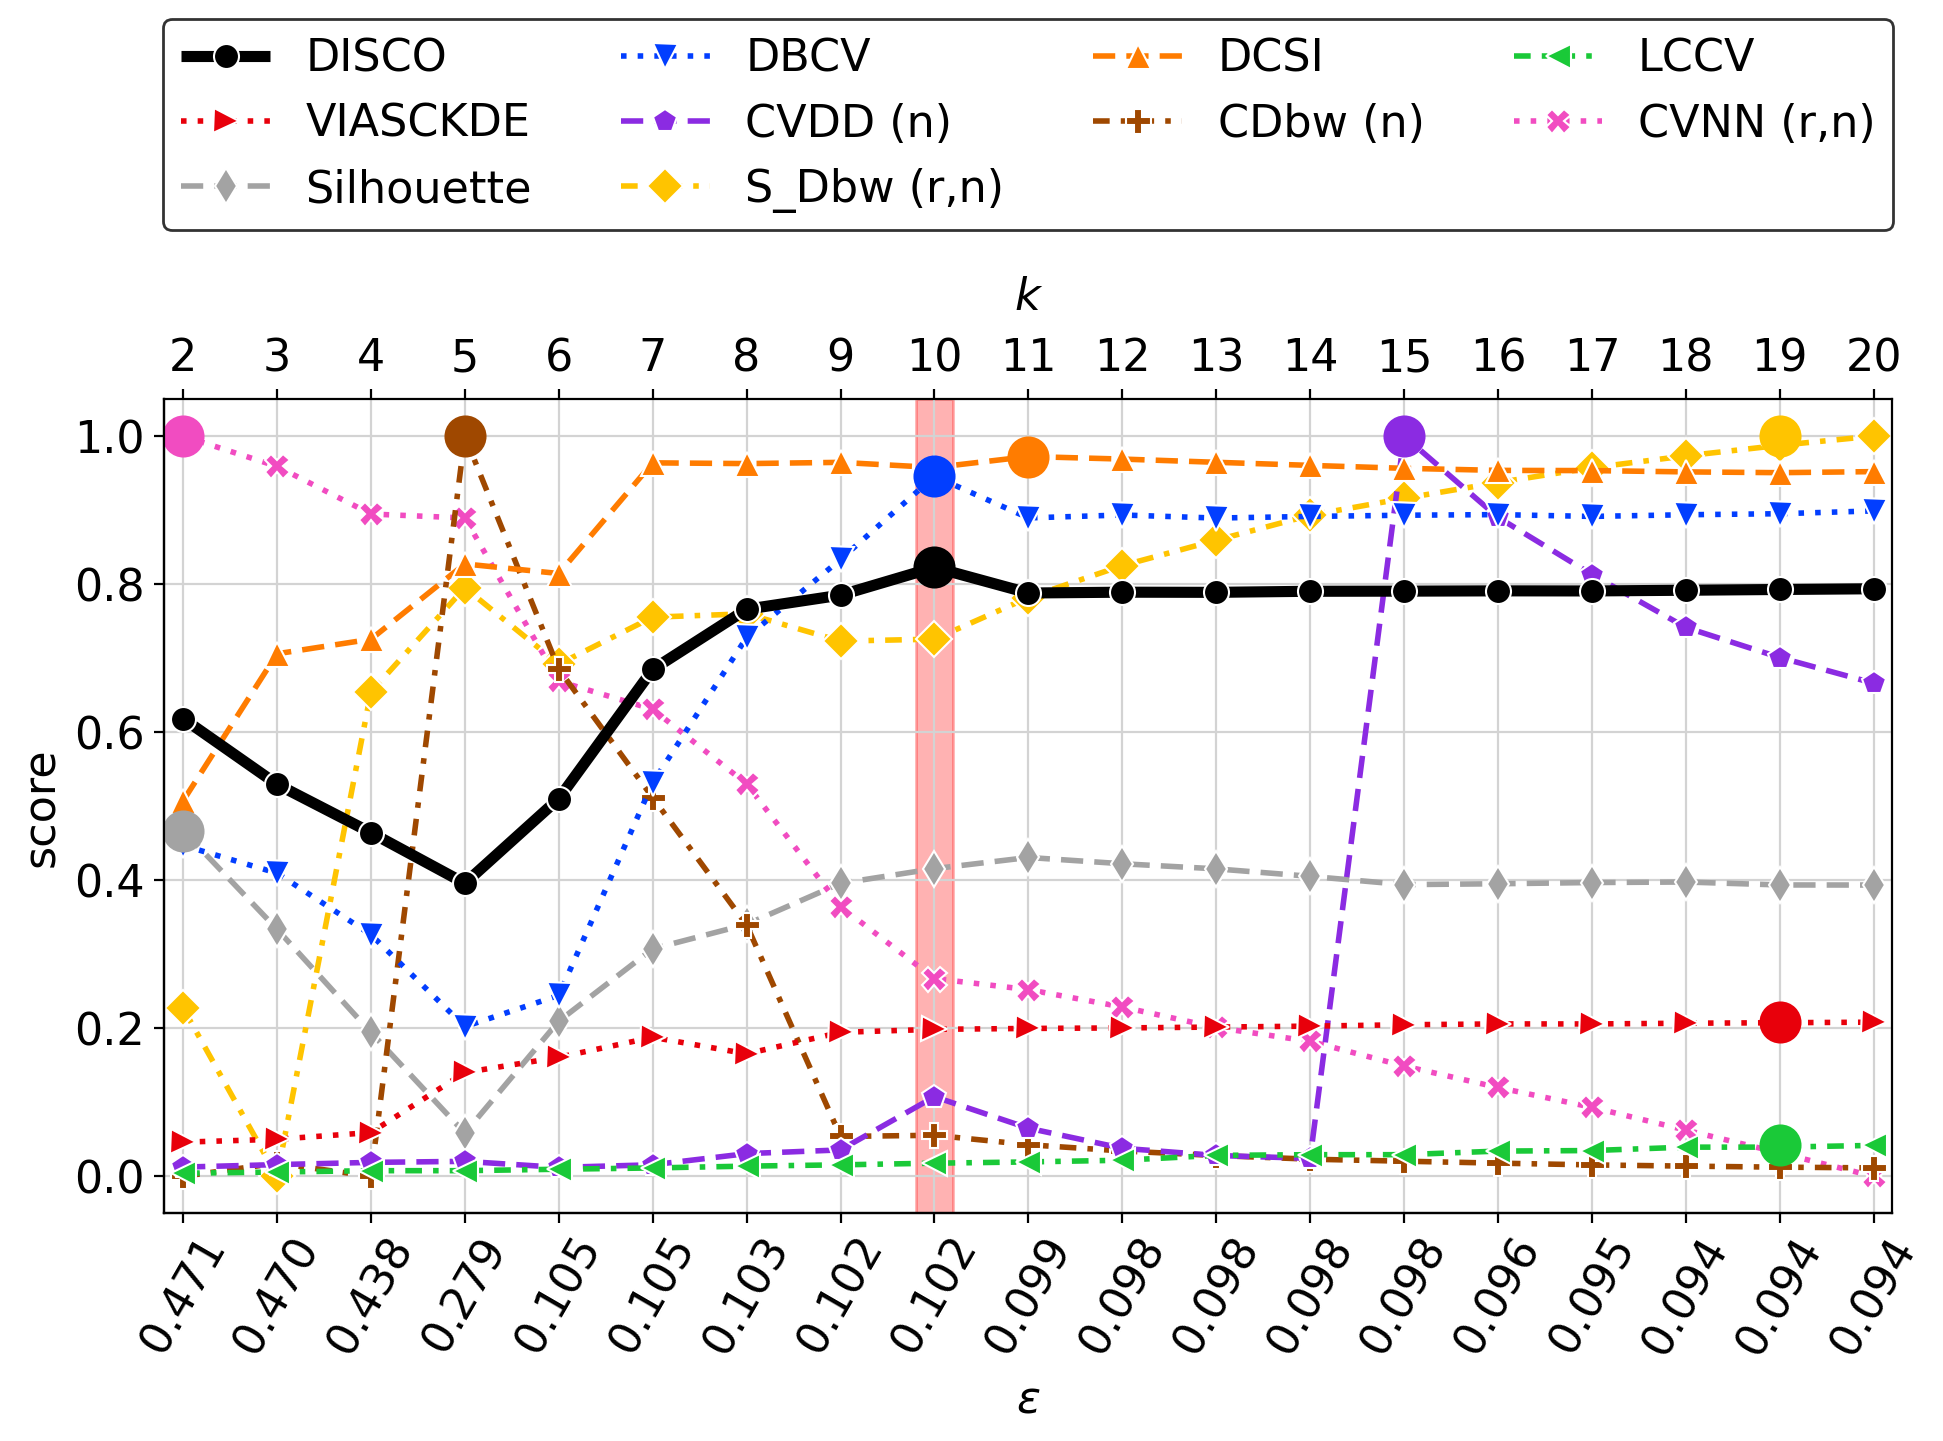

In [234]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot
import seaborn as sns

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "dataset", "value", "measure", x_label="$\\epsilon$", y_label="score", x_range=x_range, y_range=(None, None), figsize=(10,7.5), sizes=[4] + [2] * 10, markersize=9)
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("$k$", labelpad=10)
ax2.set_xticks(ks)
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("$\\epsilon$", labelpad=5)
ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
ax1.axvspan(9.8, 10.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.18))

palette = ["black"] + sns.color_palette("bright")
np.array(list(palette), dtype=object)
palette = palette[: len(peak_positions)]

markers = ["o"] + ["v", "^", "<", ">", "p", "P", "X", "d", "D", "H"]
markers = np.array(markers)[:len(peak_positions)]

for i in range(len(peak_positions)):
    ax1.scatter(peak_positions[i, 0], peak_positions[i, 1], s=200, marker="o", color=palette[i], zorder=3)

plt.savefig("imgs/find_eps_dbscan.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

In [22]:
import pandas as pd
import glob

path = "results/find_kcenter_k/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
eval_results = df_.to_dict(orient="list")

In [23]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

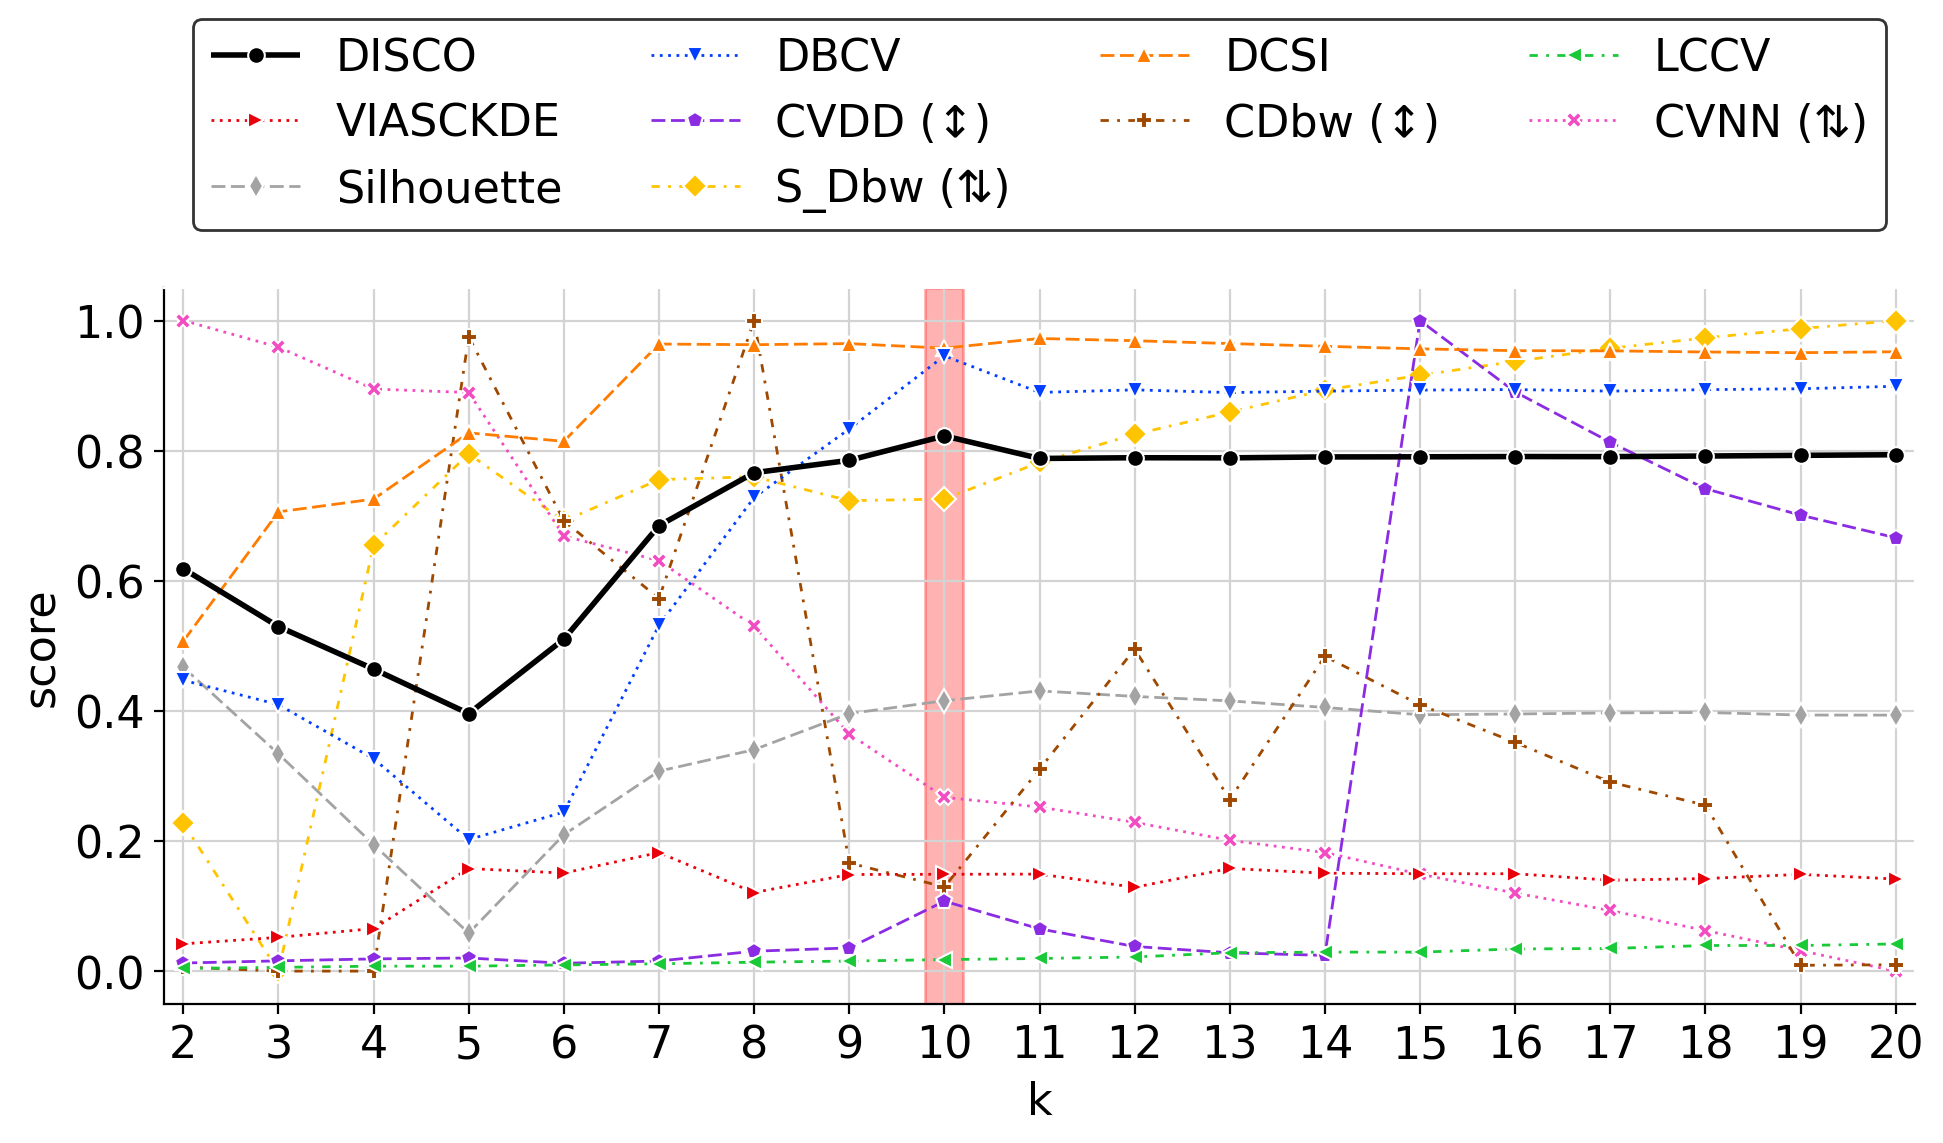

In [27]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(
    df, "dataset", "value", "measure", y_label="score", x_label="k", x_range=x_range, y_range=(None, None), figsize=(10,6)
)
ax1 = fig.axes[0]
# ax2 = ax1.twiny()
# ax2.set_xlabel("k", labelpad=10)
# ax2.set_xticks(ks)
# ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("k", labelpad=5)
ax1.set_xticks(ks)
ax1.axvspan(9.8, 10.2, alpha=0.3, color="red")
# ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/find_k_kcenter.png", bbox_inches="tight", pad_inches=0)

In [168]:
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from src.Evaluation import disco_score, disco_samples

def disco_score_balanced(X, l):
    disco_values = disco_samples(X, l)
    disco_values_per_cluster = []
    for c in set(l):
        disco_values_per_cluster.append(disco_values[l==c].mean())
    return np.array(disco_values_per_cluster)

# dataset = DensityDatasets.complex9
dataset = DensityDatasets.aggregation
# dataset = RealWorldDatasets.Synth_high
X, l = dataset.standardized_data_cached

ks = range(2, 21)
dctree = DCTree(X, min_points=5, min_points_mr=2)
eps_list = [dctree.get_eps_for_k(k) for k in ks]
kcenter_labels = [dctree.get_k_center(k) for k in ks]
dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]

# kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
# dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [169]:
kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

In [174]:
print("kcenter_k:", [len(set(l_)) for l_ in kcenter_labels])
print("dbscan_k:", [len(set(l_)) for l_ in dbscan_labels])

kcenter_k: [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
dbscan_k: [2, 3, 4, 5, 27, 27, 28, 32, 32, 38, 38, 36, 39, 39, 38, 36, 35, 33, 34]


In [171]:
kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [172]:
import pandas as pd

data_dict = {
    "k": ks,
    "eps": eps_list,
    "kcenter_disco": kcenter_disco_results,
    "dbscan_disco": dbscan_disco_results,
    "dataset": dataset.name,
}

df = pd.DataFrame(data_dict)

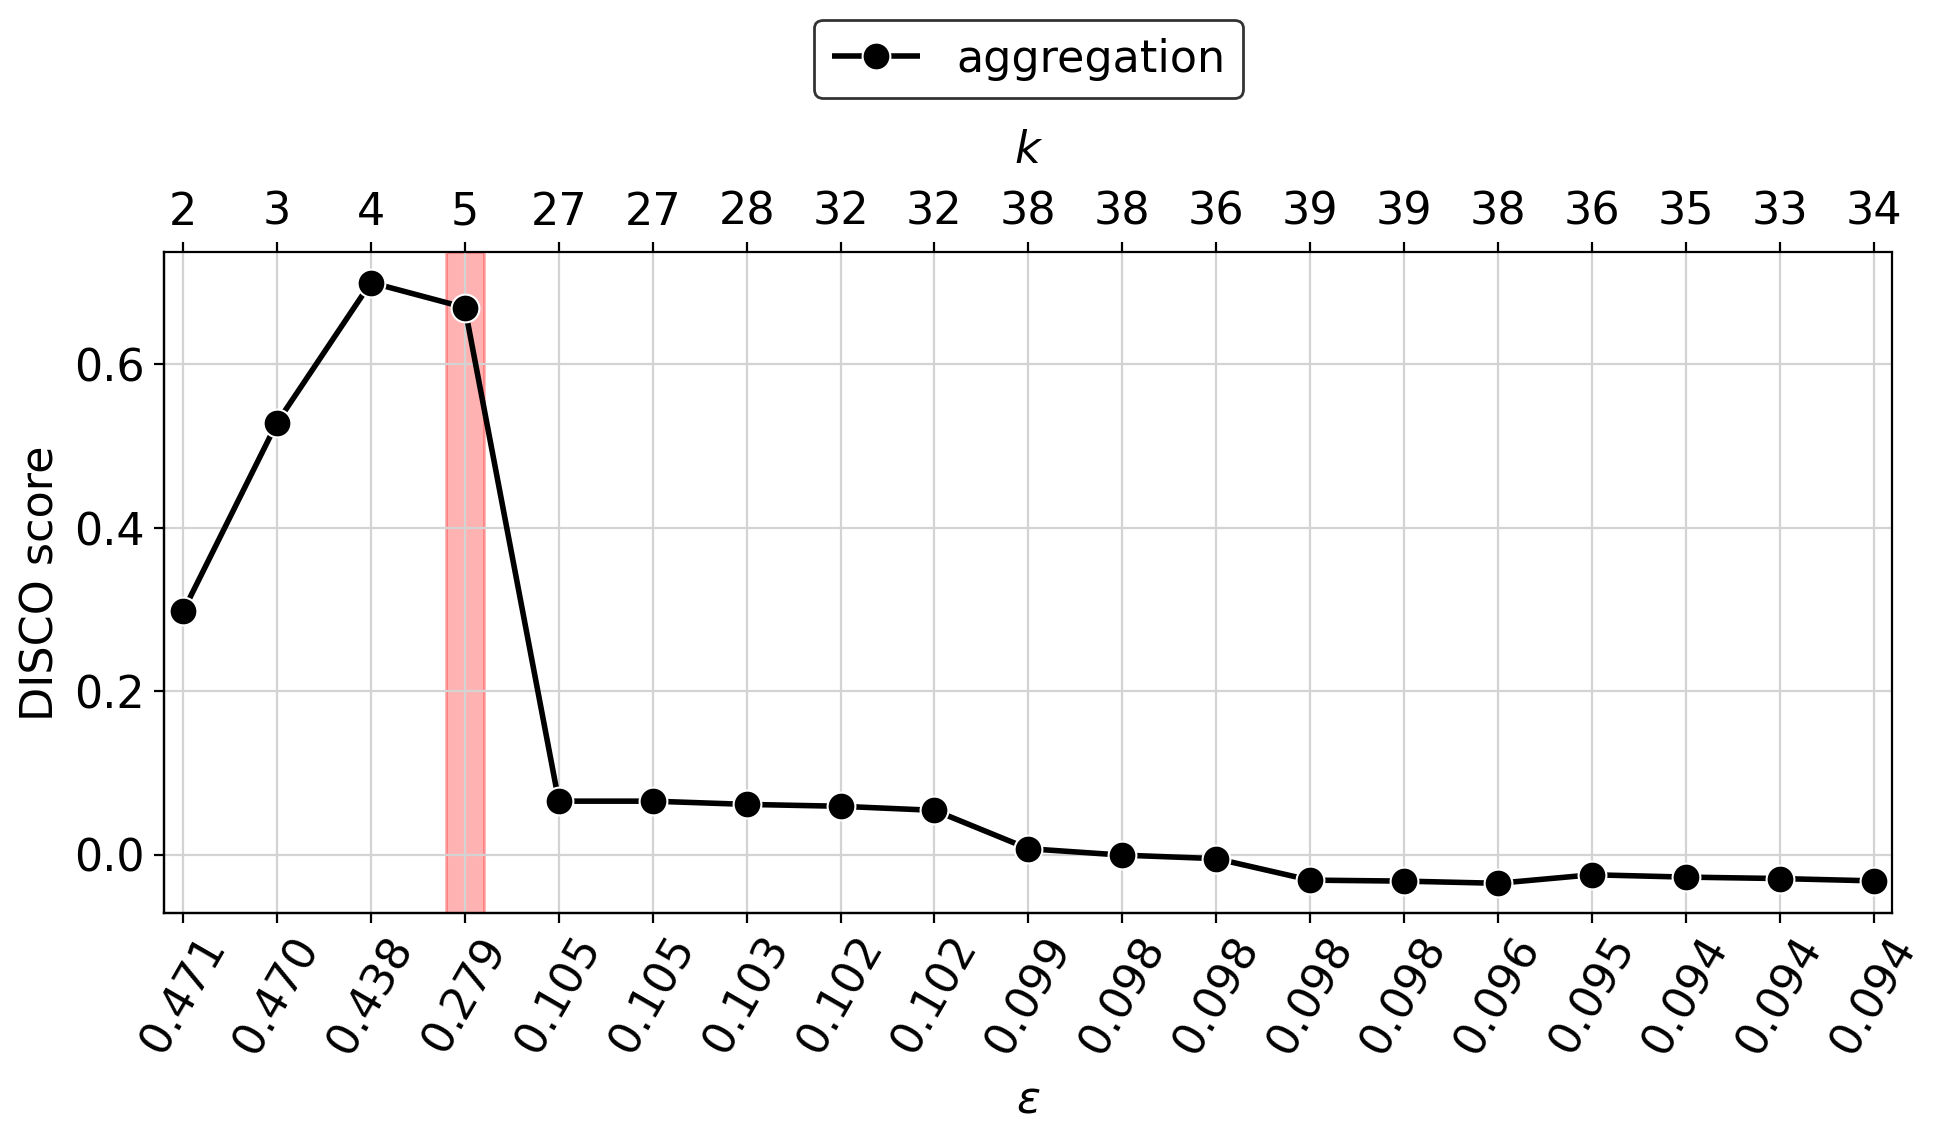

In [177]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "k", "dbscan_disco", "dataset", x_label="epsilon", y_label="DISCO score", x_range=x_range, y_range=(None, None), order=[dataset.name])
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("$k$", labelpad=10)
ax2.set_xticks(ks, [len(set(l_)) for l_ in dbscan_labels])
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("$\\epsilon$", labelpad=5)

ax1.set_xticks(ks, labels=map(lambda x: f"${x:.3f}$", np.round(eps_list, 3)), rotation=60)
ax1.axvspan(4.8, 5.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/aggregation_find_k_eps.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [132]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )

cmap = truncate_colormap(plt.colormaps["gist_rainbow"], 0.0, 0.85)

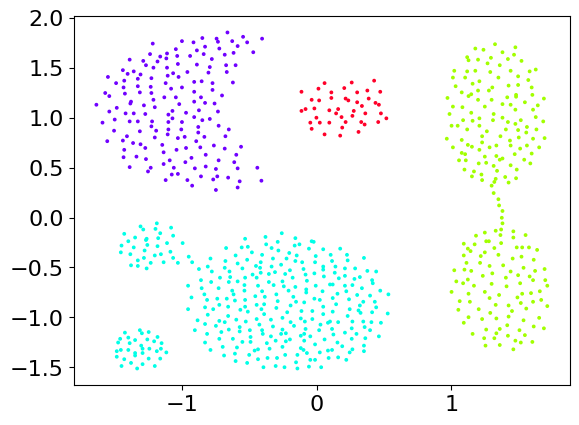

In [133]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[np.argmax(kcenter_disco_results)], cmap=cmap)
plt.show()

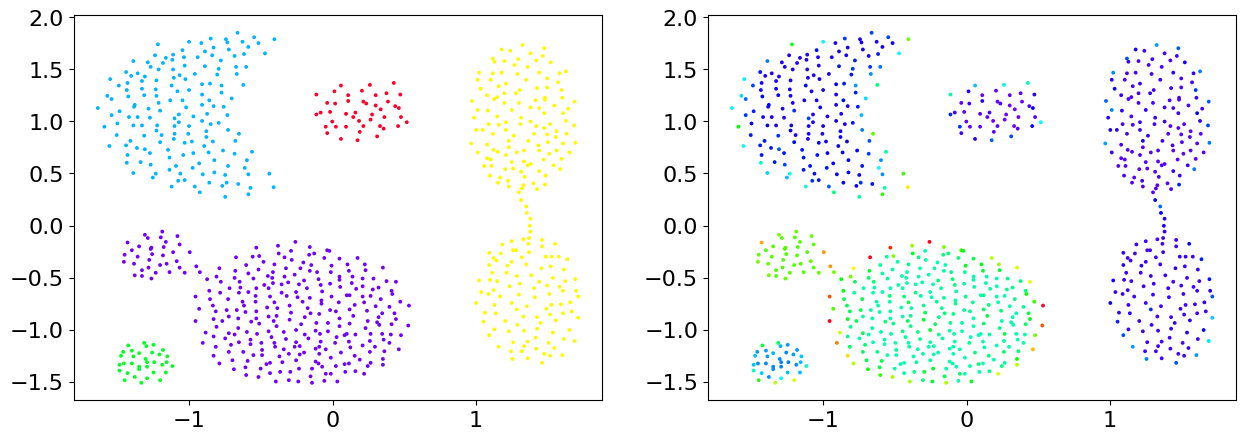

In [134]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[3], cmap=cmap)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=3, c=disco_samples(X, kcenter_labels[3]), cmap=cmap)
plt.show()

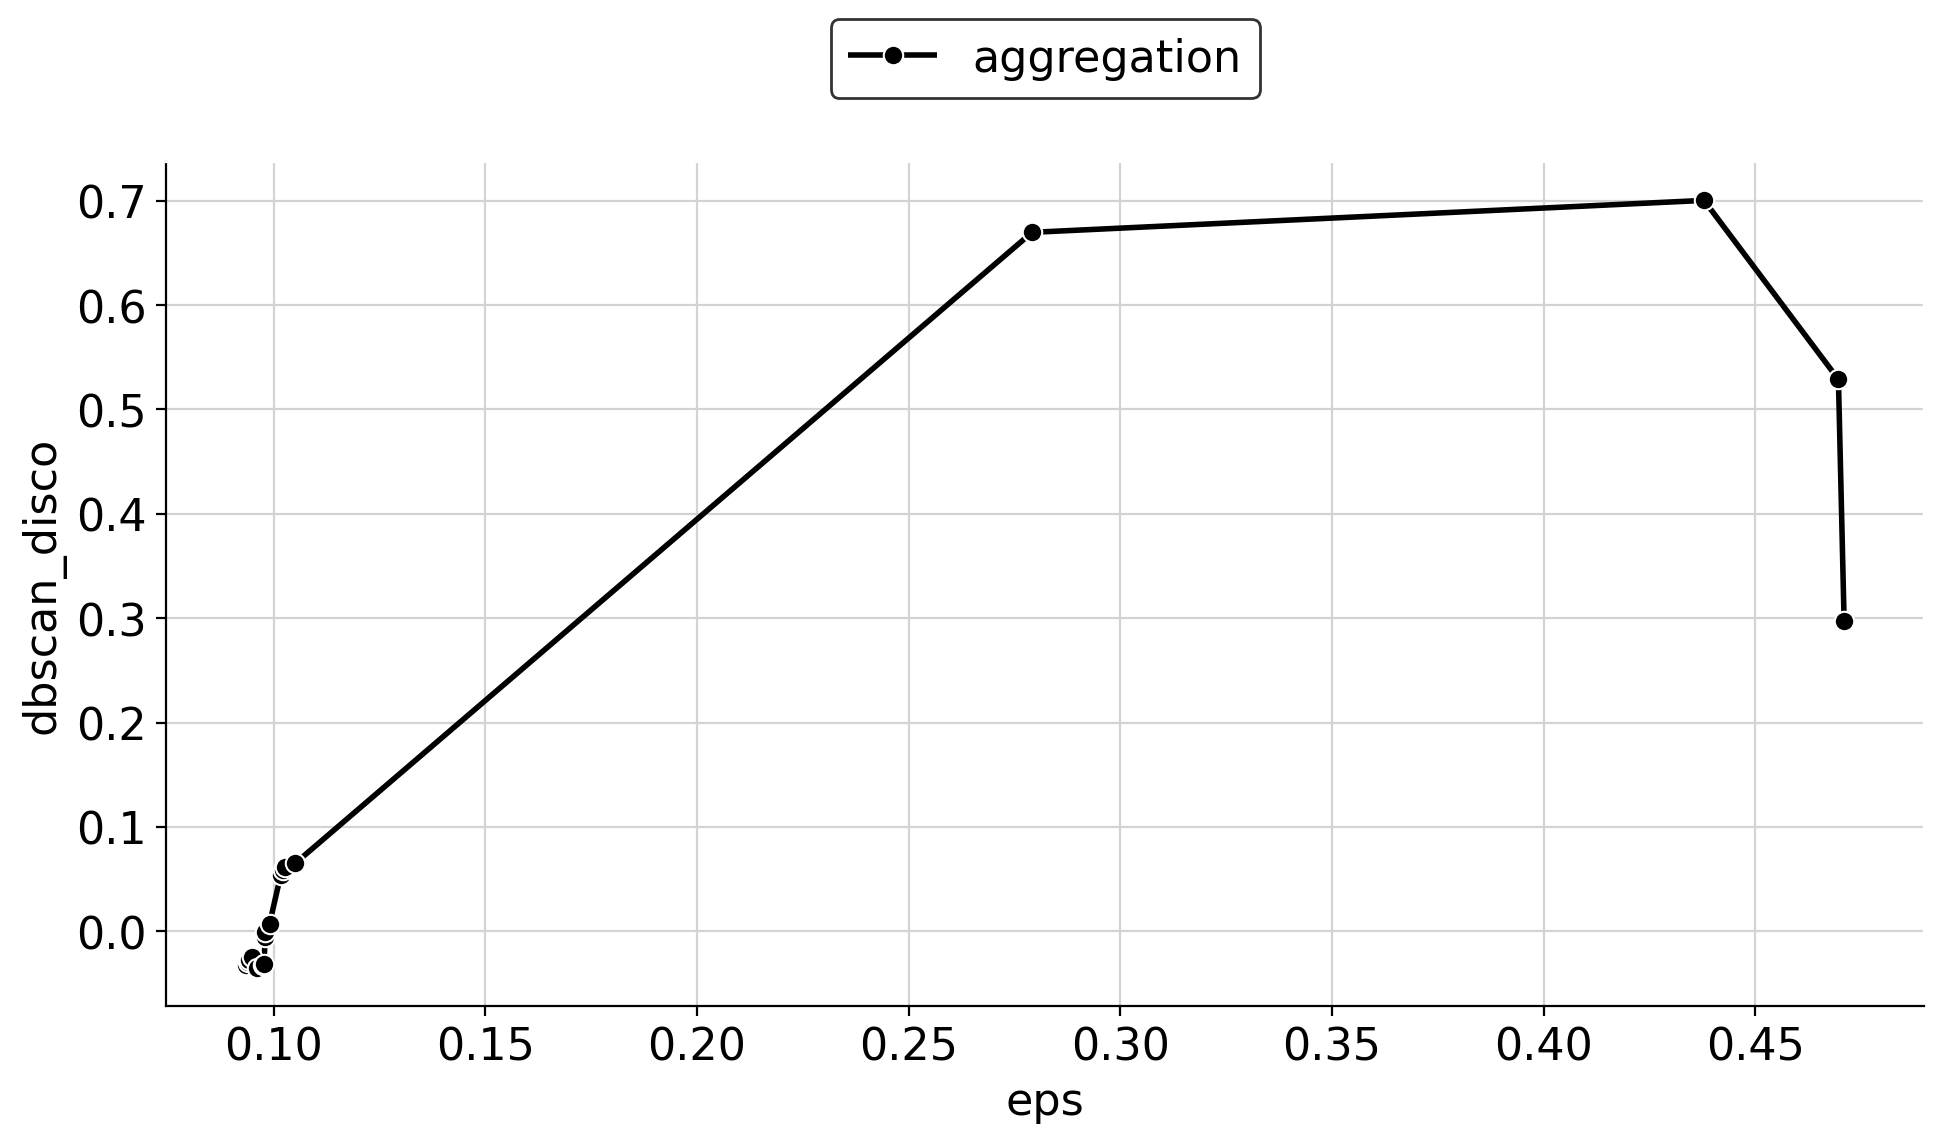

In [135]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 1
x_range = None, None

plot_lineplot(df, "eps", "dbscan_disco", "dataset", x_range=x_range, y_range=(None, None), order=[dataset.name])
plt.savefig("imgs/Synth_high_find_eps.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

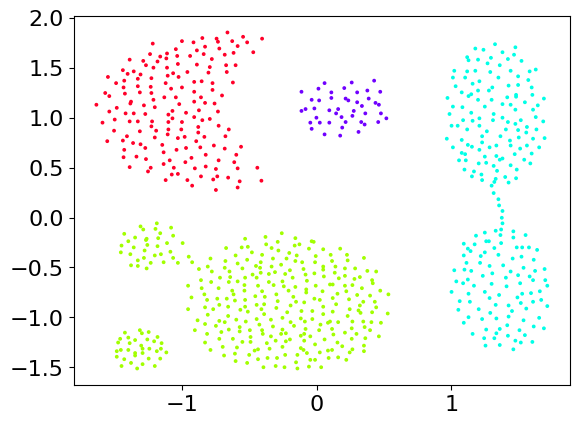

In [20]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=dbscan_labels[np.argmax(dbscan_disco_results)], cmap=cmap)
plt.show()

In [52]:
import numpy as np 

l__ = np.random.choice(170, len(l))
print(f"Nr of Clusters: {len(set(l__))}, DISCO: {disco_score(X, l__)}")

Nr of Clusters: 168, DISCO: -0.6228814662690386


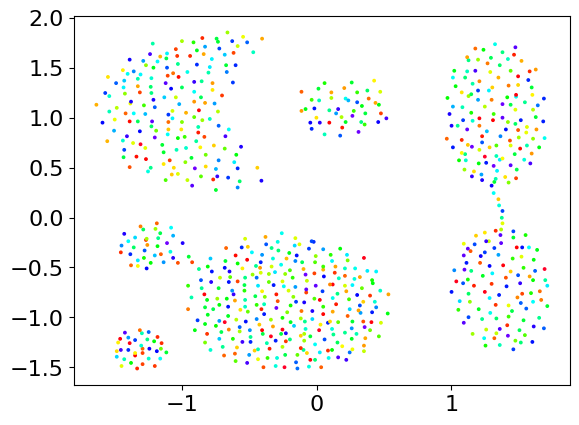

In [53]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l__, cmap=cmap)
plt.show()

In [ ]:
from src.Evaluation import disco_score
import numpy as np

ks = np.array([range(1, 300) for j in range(10)]).flatten()

np.random.seed(0)

ls = [np.random.choice(i, len(l)) for i in ks]
disco_values = [disco_score(X, l) for l in ls]

In [ ]:
results = np.hstack((np.array(ls), ks[:, np.newaxis], np.array(disco_values)[:, np.newaxis]))
np.save(".cache/increasing_labelset.npy", results)

In [137]:
results = np.load(".cache/increasing_labelset.npy")
ls = results[:, :-2]
ks = results[:, -2]
disco_values = results[:, -1]

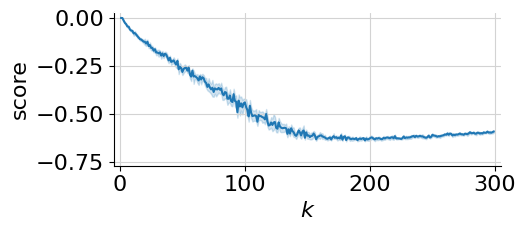

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dict = {
    "k": ks,
    "disco": disco_values,
}
df = pd.DataFrame(data_dict)

plt.figure(figsize=(5, 2))
ax = sns.lineplot(df, x="k", y="disco")
ax.set_xlabel("$k$")
ax.set_ylabel("score")
ax.set_ylim(-0.77, None)
ax.set_yticks(np.arange(-0.75,0.1, 0.25))
ax.set_xlim(-5, 305)

ax.set_facecolor("white")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("white")
ax.spines["top"].set_color("white")
ax.grid(color="lightgray")

plt.savefig("imgs/increasing_labelset.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()